# Problème 2: Collecte de données Yahoo Finance (2012-2023)



In [28]:
import yfinance as yf
import pandas as pd
import os

def fetch_yahoo_finance(tickers, start='2012-01-03', end='2023-02-01', out_path='yahoo_data.csv'):
    """Télécharge les données Yahoo Finance pour une liste de tickers jusqu'au 3 janvier 2023"""
    
    print(f"Téléchargement de {len(tickers)} titres...")
    all_data = []
    
    for i, ticker in enumerate(tickers):
        try:
            stock = yf.Ticker(ticker)
            data = stock.history(start=start, end=end)
            
            if len(data) > 0:
                # Filtrer jusqu'au 3 janvier 2023 inclus
                data = data[data.index <= '2023-01-03']
                
                data = data[['Close']].copy()
                data.reset_index(inplace=True)
                data['ticker'] = ticker
                data.columns = ['date', 'adj_close', 'ticker']
                #calcul des rendements
                data['returns'] = data['adj_close'].pct_change()
                data = data[['date', 'ticker', 'adj_close', 'returns']]
                all_data.append(data)
                
        except Exception as e:
            print(f"Erreur pour {ticker}: {e}")
    
    if all_data:
        df = pd.concat(all_data, ignore_index=True)
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values(['ticker', 'date']).reset_index(drop=True)
        df.to_csv(out_path, index=False)
        print(f"Données sauvegardées: {len(df):,} observations")
        return df
    else:
        print("Aucune donnée récupérée")
        return pd.DataFrame()

In [17]:
# Liste complète des 10 titres requis (mêmes que CRSP mais avec tickers Yahoo)
tickers_yahoo = [
    # INDICE DE MARCHÉ
    'SPY',              # SPDR S&P 500 ETF Trust
    
    # SECTEUR FINANCIER
    'EFX',              # Equifax Inc. 
    'JPM',              # JPMorgan Chase & Co.
    'GS',              # Goldman Sachs Group Inc.
    
    # SECTEUR TECHNOLOGIQUE
    'EA',               # Electronic Arts Inc.
    'JBL',              # Jabil Inc.
    'GOOGL',            # Alphabet Inc. (Class A)
    
    # SECTEUR ÉNERGÉTIQUE
    'EOG',              # EOG Resources Inc.
    'JKS',              # JinkoSolar Holding Co.
    'GTE',              # Gran Tierra Energy Inc.
]

# Mapping pour organisation par secteur
secteurs_mapping = {
    'SPY': 'Indice de marché',
    'EFX': 'Secteur financier', 'JPM': 'Secteur financier', 'GS': 'Secteur financier',
    'EA': 'Secteur technologique', 'JBL': 'Secteur technologique', 'GOOGL': 'Secteur technologique',
    'EOG': 'Secteur énergétique', 'JKS': 'Secteur énergétique', 'GTE': 'Secteur énergétique'
}

In [18]:
# TÉLÉCHARGEMENT ET ORGANISATION DES DONNÉES

# Vérifier si on a tous les 10 titres requis ET la bonne période
if os.path.exists('donnees_yahoo_probleme2.csv'):
    df_temp = pd.read_csv('donnees_yahoo_probleme2.csv')
    df_temp['date'] = pd.to_datetime(df_temp['date'], utc=True)
    tickers_existants = df_temp['ticker'].unique()
    date_max = df_temp['date'].max().date()
    
    # Vérifier 10 titres ET période jusqu'au 3 janvier 2023
    if (len(tickers_existants) == 10 and 
        all(ticker in tickers_existants for ticker in tickers_yahoo) and
        date_max >= pd.to_datetime('2023-01-03').date()):
        df = df_temp.copy()
    else:
        df = fetch_yahoo_finance(tickers_yahoo, out_path='donnees_yahoo_probleme2.csv')
else:
    df = fetch_yahoo_finance(tickers_yahoo, out_path='donnees_yahoo_probleme2.csv')

# Ajouter la colonne secteur et organiser les données
df['secteur'] = df['ticker'].map(secteurs_mapping)
df = df[['date', 'ticker', 'secteur', 'adj_close', 'returns']]

# Créer les fichiers individuels
os.makedirs('donnees_individuelles_yahoo', exist_ok=True)
for ticker in tickers_yahoo:
    fichier = f'donnees_individuelles_yahoo/{ticker}.csv'
    data_ticker = df[df['ticker'] == ticker]
    data_ticker.to_csv(fichier, index=False)

# RÉSUMÉ DES DONNÉES
print(f"\nStructure: {df.shape[0]:,} observations, {df.shape[1]} colonnes")
print(f"Période: {df['date'].min().date()} à {df['date'].max().date()}")

print(f"\nObservations par titre:")
obs_par_titre = df.groupby(['ticker', 'secteur']).size().reset_index(name='observations')
for _, row in obs_par_titre.iterrows():
    print(f"  {row['ticker']} ({row['secteur']}): {row['observations']:,} obs")


Structure: 27,690 observations, 5 colonnes
Période: 2012-01-03 à 2023-01-03

Observations par titre:
  EA (Secteur technologique): 2,769 obs
  EFX (Secteur financier): 2,769 obs
  EOG (Secteur énergétique): 2,769 obs
  GOOGL (Secteur technologique): 2,769 obs
  GS (Secteur financier): 2,769 obs
  GTE (Secteur énergétique): 2,769 obs
  JBL (Secteur technologique): 2,769 obs
  JKS (Secteur énergétique): 2,769 obs
  JPM (Secteur financier): 2,769 obs
  SPY (Indice de marché): 2,769 obs


# Problème 2(a): Statistiques descriptives et graphiques des rendements



In [43]:
# Importer les librairies pour les graphiques et statistiques
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Configuration des graphiques
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Supprimer les valeurs manquantes pour les calculs
df_clean = df.dropna(subset=['returns'])

print("=== STATISTIQUES DESCRIPTIVES DES RENDEMENTS ===\n")

# Calculer les statistiques descriptives par titre
stats_summary = []

for ticker in tickers_yahoo:
    data_ticker = df_clean[df_clean['ticker'] == ticker]['returns']
    secteur = secteurs_mapping[ticker]
    
    # Ratio de Sharpe (annualisé, en supposant un taux sans risque de 0)
    sharpe_ratio = (data_ticker.mean() / data_ticker.std()) * np.sqrt(252) if data_ticker.std() != 0 else 0
    
    # Rendement cumulatif total sur la période
    cumulative_return = (1 + data_ticker).prod() - 1
    
    # Rendement annualisé (CAGR)
    num_years = len(data_ticker) / 252.0
    annualized_return = ((1 + cumulative_return) ** (1 / num_years)) - 1 if num_years > 0 else 0
    
    stats_dict = {
        'Ticker': ticker,
        'Secteur': secteur,
        'Observations': len(data_ticker),
        'Moyenne': data_ticker.mean(),
        'Écart-type': data_ticker.std(),
        'Minimum': data_ticker.min(),
        'Maximum': data_ticker.max(),
        'Médiane': data_ticker.median(),
        'Rendement Cumulatif': cumulative_return,
        'Rendement Annuel': annualized_return,
        'Sharpe Ratio (Ann.)': sharpe_ratio,
        'Asymétrie': stats.skew(data_ticker),
        'Kurtosis': stats.kurtosis(data_ticker),
        'Jarque-Bera': stats.jarque_bera(data_ticker)[0],
        'JB p-value': stats.jarque_bera(data_ticker)[1]
    }
    stats_summary.append(stats_dict)
    
    # Afficher les statistiques pour chaque titre
    print(f"{ticker} ({secteur}):")
    print(f"  Observations: {stats_dict['Observations']:,}")
    print(f"  Moyenne: {stats_dict['Moyenne']:.6f} ({stats_dict['Moyenne']*252:.4f} annualisé)")
    print(f"  Écart-type: {stats_dict['Écart-type']:.6f} ({stats_dict['Écart-type']*np.sqrt(252):.4f} annualisé)")
    print(f"  Min/Max: {stats_dict['Minimum']:.6f} / {stats_dict['Maximum']:.6f}")
    print(f"  Médiane: {stats_dict['Médiane']:.6f}")
    print(f"  Asymétrie: {stats_dict['Asymétrie']:.4f}")
    print(f"  Kurtosis: {stats_dict['Kurtosis']:.4f}")
    print(f"  Rendement Cumulatif Total: {stats_dict['Rendement Cumulatif']:.2%}")
    print(f"  Rendement Annuel (CAGR): {stats_dict['Rendement Annuel']:.2%}")
    print(f"  Ratio de Sharpe (Annualisé): {stats_dict['Sharpe Ratio (Ann.)']:.4f}")
    print(f"  Jarque-Bera: {stats_dict['Jarque-Bera']:.2f} (p-value: {stats_dict['JB p-value']:.4f})")
    print()

# Créer un DataFrame des statistiques pour comparaison
stats_df = pd.DataFrame(stats_summary)
print("=== TABLEAU COMPARATIF DES STATISTIQUES ===")
# Réorganiser les colonnes pour une meilleure lisibilité
column_order = [
    'Ticker', 'Secteur', 'Observations', 'Moyenne', 'Écart-type',
    'Minimum', 'Maximum', 'Médiane', 'Asymétrie', 'Kurtosis', 
    'Rendement Cumulatif', 'Rendement Annuel', 'Sharpe Ratio (Ann.)', 
    'Jarque-Bera', 'JB p-value'
]
stats_df = stats_df[column_order]
print(stats_df.round(4).to_string(index=False))

# Créer un tableau comparatif simplifié avec les statistiques clés
print("\n" + "="*80)
print("=== TABLEAU COMPARATIF SIMPLIFIÉ ===")
simplified_columns = [
    'Ticker', 'Moyenne', 'Écart-type', 'Asymétrie', 'Kurtosis', 
    'Rendement Annuel', 'Rendement Cumulatif', 'Sharpe Ratio (Ann.)'
]
stats_df_simplified = stats_df[simplified_columns].copy()
print(stats_df_simplified.round(4).to_string(index=False))

=== STATISTIQUES DESCRIPTIVES DES RENDEMENTS ===

SPY (Indice de marché):
  Observations: 2,768
  Moyenne: 0.000528 (0.1331 annualisé)
  Écart-type: 0.010715 (0.1701 annualisé)
  Min/Max: -0.109424 / 0.090603
  Médiane: 0.000597
  Asymétrie: -0.5569
  Kurtosis: 13.4799
  Rendement Cumulatif Total: 267.60%
  Rendement Annuel (CAGR): 12.58%
  Ratio de Sharpe (Annualisé): 0.7823
  Jarque-Bera: 21100.03 (p-value: 0.0000)

EFX (Secteur financier):
  Observations: 2,768
  Moyenne: 0.000778 (0.1961 annualisé)
  Écart-type: 0.016837 (0.2673 annualisé)
  Min/Max: -0.147798 / 0.149406
  Médiane: 0.000962
  Asymétrie: -0.2903
  Kurtosis: 12.4243
  Rendement Cumulatif Total: 480.59%
  Rendement Annuel (CAGR): 17.37%
  Ratio de Sharpe (Annualisé): 0.7335
  Jarque-Bera: 17842.00 (p-value: 0.0000)

JPM (Secteur financier):
  Observations: 2,768
  Moyenne: 0.000743 (0.1872 annualisé)
  Écart-type: 0.016969 (0.2694 annualisé)
  Min/Max: -0.149649 / 0.180125
  Médiane: 0.000488
  Asymétrie: 0.2647
  Kur


=== GRAPHIQUES DES SÉRIES CHRONOLOGIQUES ===



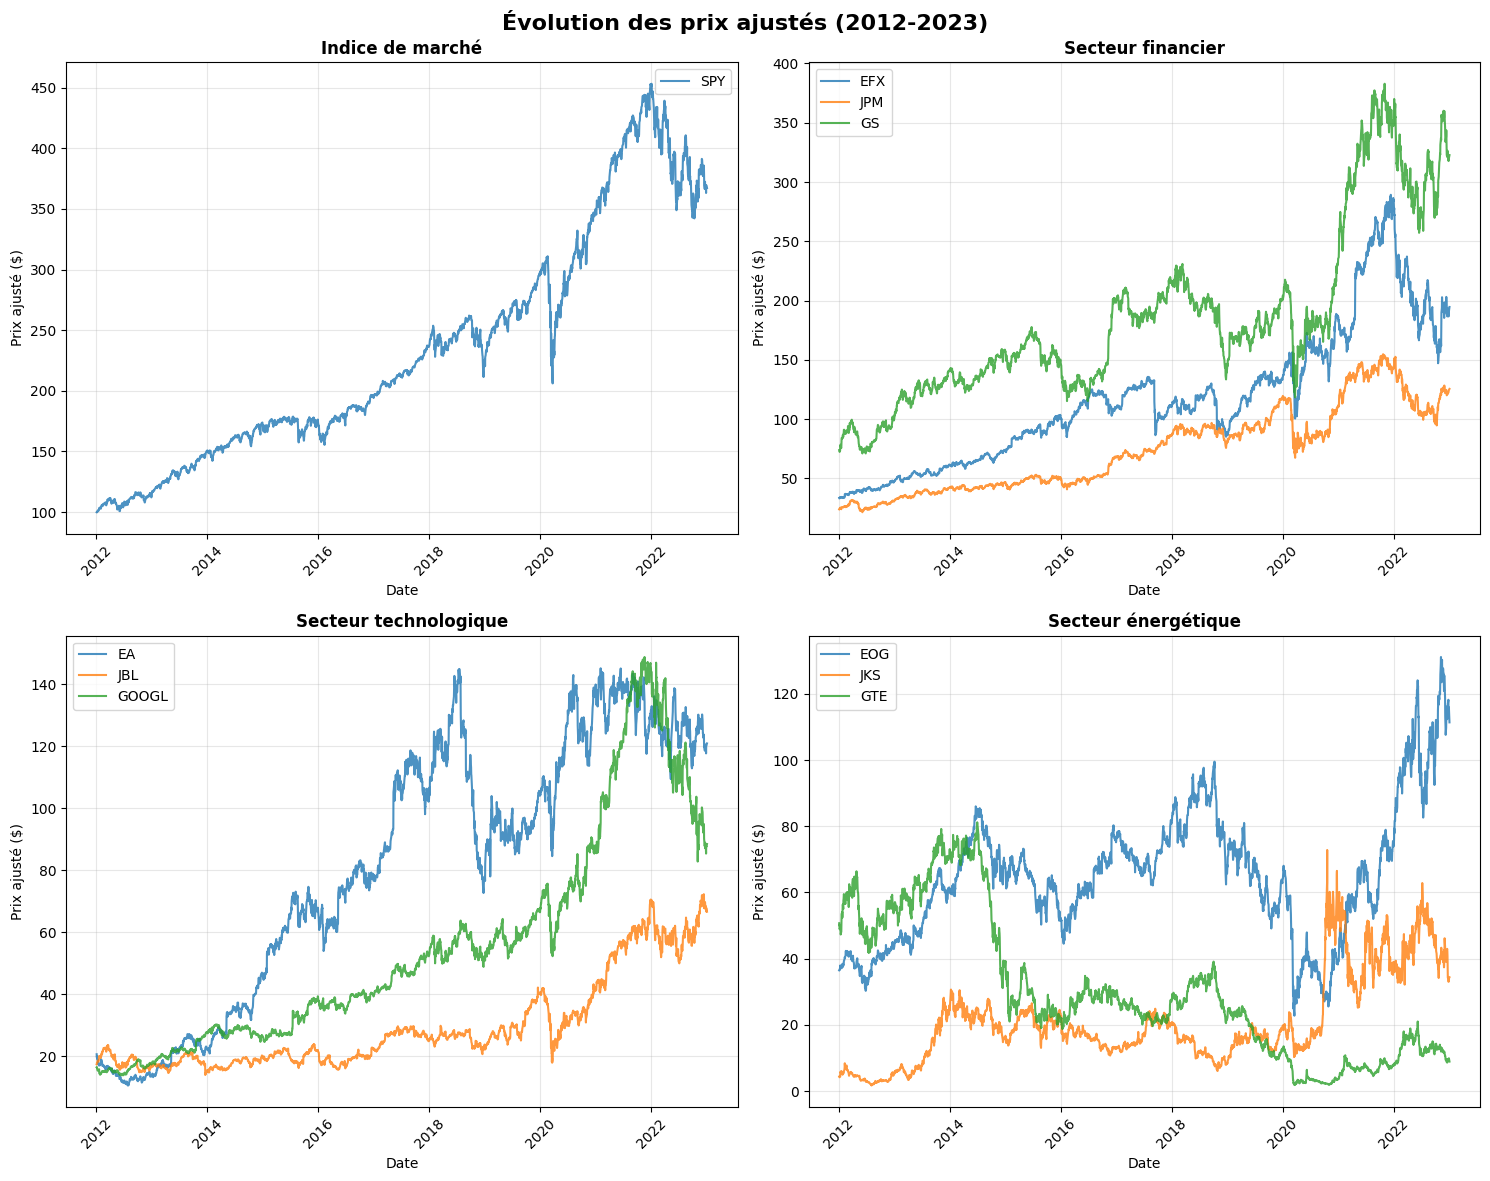

In [47]:
# GRAPHIQUES DES SÉRIES CHRONOLOGIQUES DES PRIX
print("\n=== GRAPHIQUES DES SÉRIES CHRONOLOGIQUES ===\n")

# 1. Graphique des prix ajustés
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Évolution des prix ajustés (2012-2023)', fontsize=16, fontweight='bold')

# Organiser par secteur
secteurs = ['Indice de marché', 'Secteur financier', 'Secteur technologique', 'Secteur énergétique']
colors = ['blue', 'green', 'red', 'orange']

for i, secteur in enumerate(secteurs):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    tickers_secteur = [t for t in tickers_yahoo if secteurs_mapping[t] == secteur]
    
    for ticker in tickers_secteur:
        data_ticker = df[df['ticker'] == ticker]
        ax.plot(data_ticker['date'], data_ticker['adj_close'], 
                label=ticker, linewidth=1.5, alpha=0.8)
    
    ax.set_title(f'{secteur}', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Prix ajusté ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
#Problème 2 b - VaR et ES Historiques (Non-Paramétriques)
print("\n=== CALCUL DE LA VaR ET ES HISTORIQUES (NON-PARAMÉTRIQUES) ===\n")
# Conformément aux instructions, nous nous concentrons sur l'indice de marché, 
# une action technologique et une action énergétique.
# Nous choisissons GOOGL et EOG comme représentants de leurs secteurs.
tickers_analyse_b = ['SPY', 'GOOGL', 'EOG']
alphas = [0.05, 0.01]  # Niveaux de confiance de 5% et 1%

results = []

# Boucle sur chaque titre à analyser
for ticker in tickers_analyse_b:
    returns = df_clean[df_clean['ticker'] == ticker]['returns']
    secteur = secteurs_mapping[ticker]
    
    # Boucle sur chaque niveau de alpha
    for alpha in alphas:
        # 1. Calcul de la VaR historique
        # C'est le quantile alpha de la distribution des rendements.
        # On prend le négatif car la VaR est exprimée en perte positive.
        var_hist = -returns.quantile(alpha)
        
        # 2. Calcul de l'ES (Expected Shortfall) historique
        # C'est la moyenne des rendements qui sont inférieurs ou égaux au quantile (c'est-à-dire pires que la VaR).
        es_hist = -returns[returns <= -var_hist].mean()
        
        results.append({
            'Ticker': ticker,
            'Secteur': secteur,
            'Niveau de confiance (alpha)': f"{(1-alpha):.0%}",
            'VaR Historique': var_hist,
            'ES Historique': es_hist
        })

# Créer un DataFrame pour présenter les résultats
results_df = pd.DataFrame(results)

print("=== VaR et ES Historiques (Non-Paramétriques) ===\n")
print(results_df.to_string(index=False))



=== CALCUL DE LA VaR ET ES HISTORIQUES (NON-PARAMÉTRIQUES) ===

=== VaR et ES Historiques (Non-Paramétriques) ===

Ticker               Secteur Niveau de confiance (alpha)  VaR Historique  ES Historique
   SPY      Indice de marché                         95%        0.016160       0.026223
   SPY      Indice de marché                         99%        0.030322       0.044758
 GOOGL Secteur technologique                         95%        0.025128       0.038521
 GOOGL Secteur technologique                         99%        0.046410       0.060258
   EOG   Secteur énergétique                         95%        0.035645       0.054021
   EOG   Secteur énergétique                         99%        0.062647       0.090259


In [52]:
#Problème 2 c - VaR et ES Paramétriques (Gaussiennes) et Comparaison
from scipy.stats import norm

# On utilise les mêmes tickers et alphas que précédemment
results_param = []

# Boucle sur chaque titre
for ticker in tickers_analyse_b:
    returns = df_clean[df_clean['ticker'] == ticker]['returns']
    secteur = secteurs_mapping[ticker]
    
    # Calculer la moyenne et l'écart-type des rendements
    mu = returns.mean()
    sigma = returns.std()
    
    # Boucle sur chaque niveau de alpha
    for alpha in alphas:
        # 1. Calcul de la VaR paramétrique (Gaussienne)
        # VaR = - (mu + sigma * Z_alpha), où Z_alpha est le quantile de la loi normale standard
        z_score = norm.ppf(alpha)
        var_param = -(mu + sigma * z_score)
        
        # 2. Calcul de l'ES paramétrique (Gaussienne)
        # ES = - (mu - sigma * (phi(Z_alpha) / alpha)), où phi est la densité de probabilité
        es_param = -(mu - sigma * (norm.pdf(z_score) / alpha))
        
        results_param.append({
            'Ticker': ticker,
            'Secteur': secteur,
            'Niveau de confiance (alpha)': f"{(1-alpha):.0%}",
            'VaR Paramétrique': var_param,
            'ES Paramétrique': es_param
        })

# Créer un DataFrame pour les résultats paramétriques
results_param_df = pd.DataFrame(results_param)

# 1. Afficher uniquement les résultats paramétriques
print("=== VaR et ES Paramétriques (Gaussiennes) ===\n")
print(results_param_df.to_string(index=False))
print("\n" + "="*80 + "\n")

# 2. Fusionner avec les résultats historiques pour comparaison
comparison_df = pd.merge(
    results_df,
    results_param_df,
    on=['Ticker', 'Secteur', 'Niveau de confiance (alpha)']
)
print("=== Comparaison des Modèles : Historique vs. Paramétrique (Gaussien) ===\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*80 + "\n")

# 3. Calculer et afficher les deltas (écarts)
delta_df = comparison_df[['Ticker', 'Secteur', 'Niveau de confiance (alpha)']].copy()
delta_df['VaR Delta (Param - Hist)'] = comparison_df['VaR Paramétrique'] - comparison_df['VaR Historique']
delta_df['ES Delta (Param - Hist)'] = comparison_df['ES Paramétrique'] - comparison_df['ES Historique']

print("=== Delta (Écart) entre les Modèles Paramétrique et Historique ===\n")
print("Un delta positif signifie que l'estimation paramétrique est plus élevée (moins de perte ou un gain).\n")
print(delta_df.to_string(index=False))


=== VaR et ES Paramétriques (Gaussiennes) ===

Ticker               Secteur Niveau de confiance (alpha)  VaR Paramétrique  ES Paramétrique
   SPY      Indice de marché                         95%          0.017097         0.021575
   SPY      Indice de marché                         99%          0.024400         0.028031
 GOOGL Secteur technologique                         95%          0.026930         0.033961
 GOOGL Secteur technologique                         99%          0.038397         0.044099
   EOG   Secteur énergétique                         95%          0.040143         0.050523
   EOG   Secteur énergétique                         99%          0.057071         0.065489


=== Comparaison des Modèles : Historique vs. Paramétrique (Gaussien) ===

Ticker               Secteur Niveau de confiance (alpha)  VaR Historique  ES Historique  VaR Paramétrique  ES Paramétrique
   SPY      Indice de marché                         95%        0.016160       0.026223          0.017097     

=== Calcul de la VaR Récursive (EWMA) pour les niveaux 95% et 99% ===

Traitement pour SPY...
Traitement pour GOOGL...
Traitement pour EOG...

Calcul terminé. Génération des graphiques...


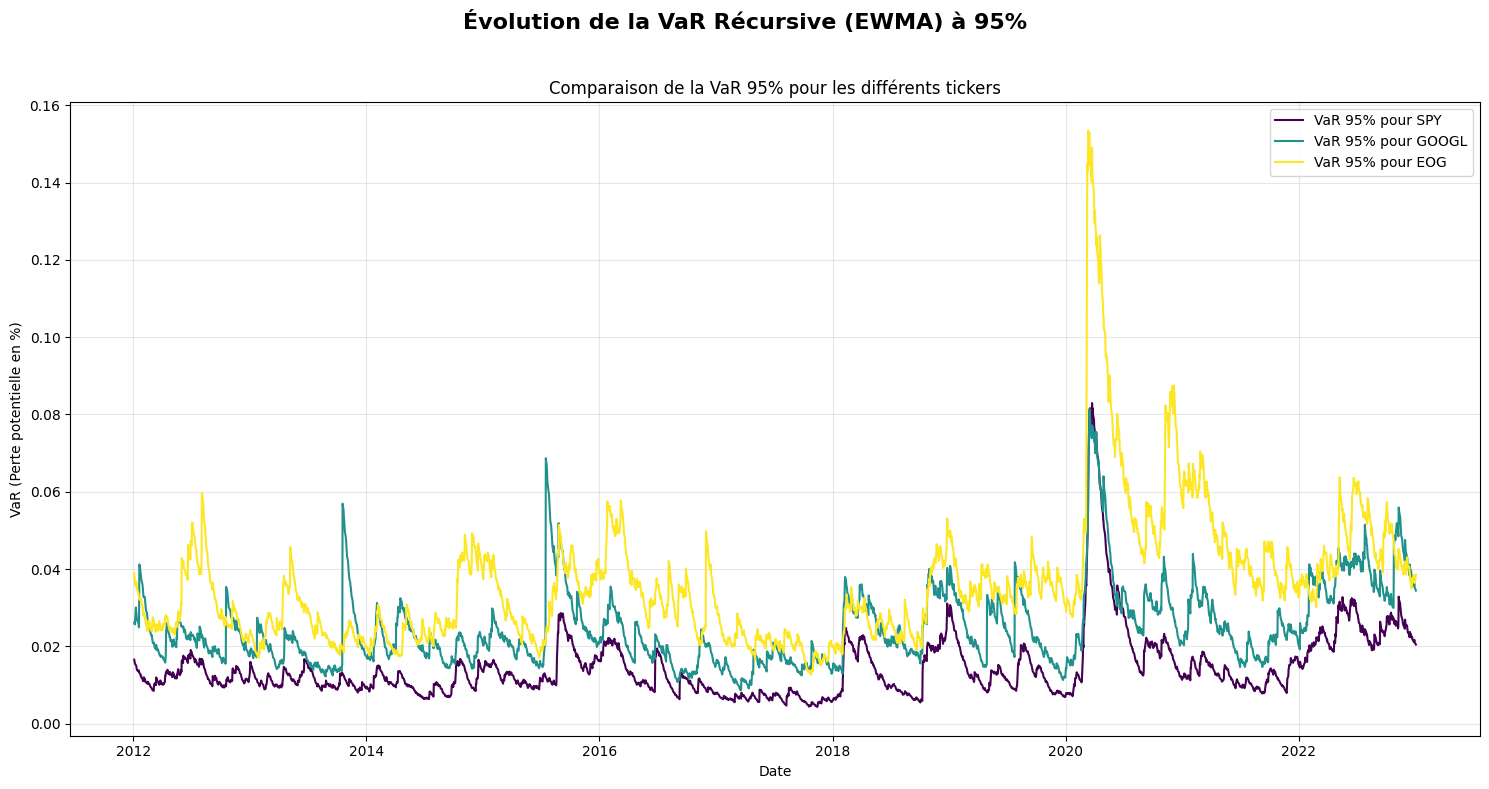

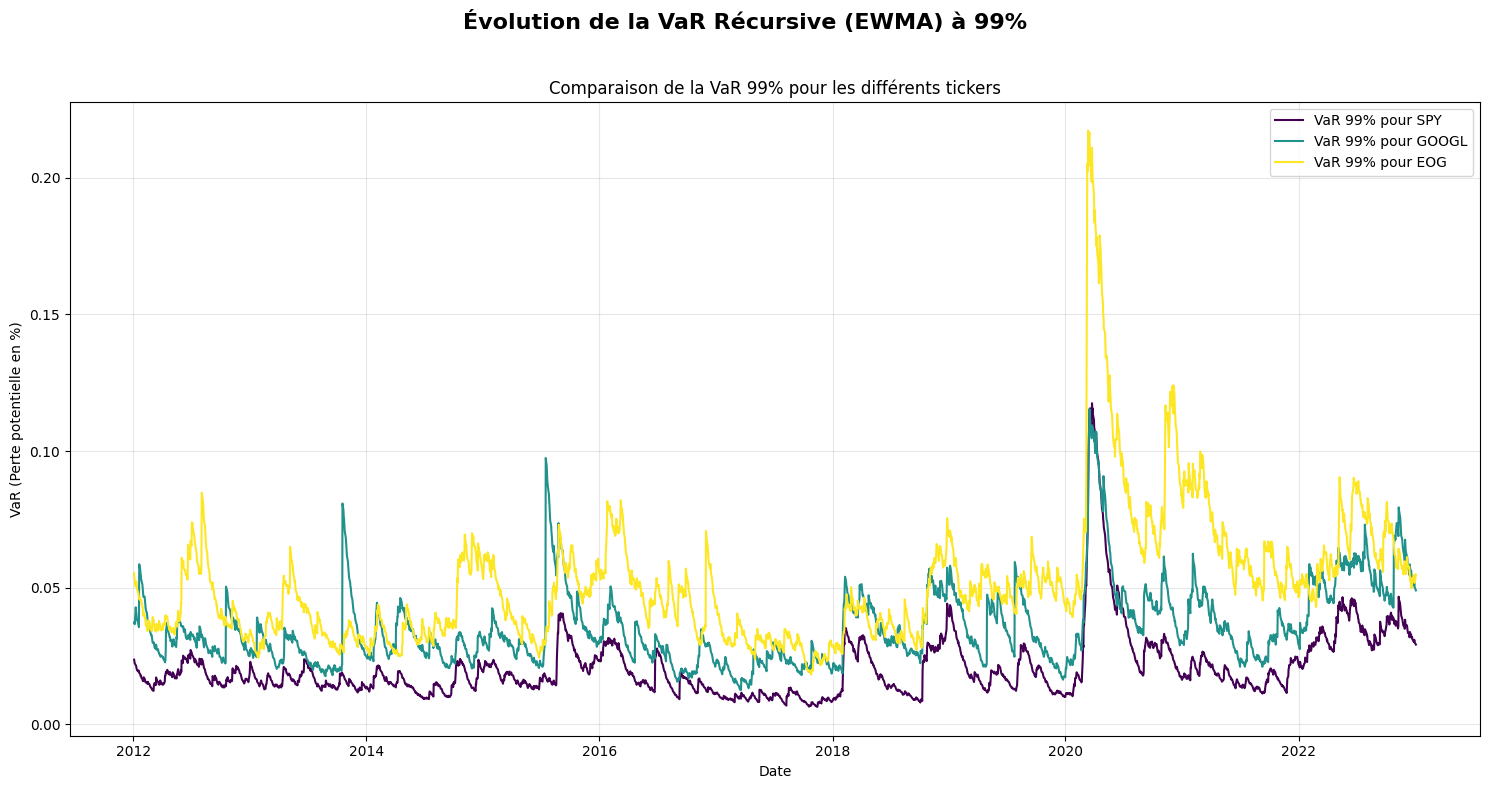

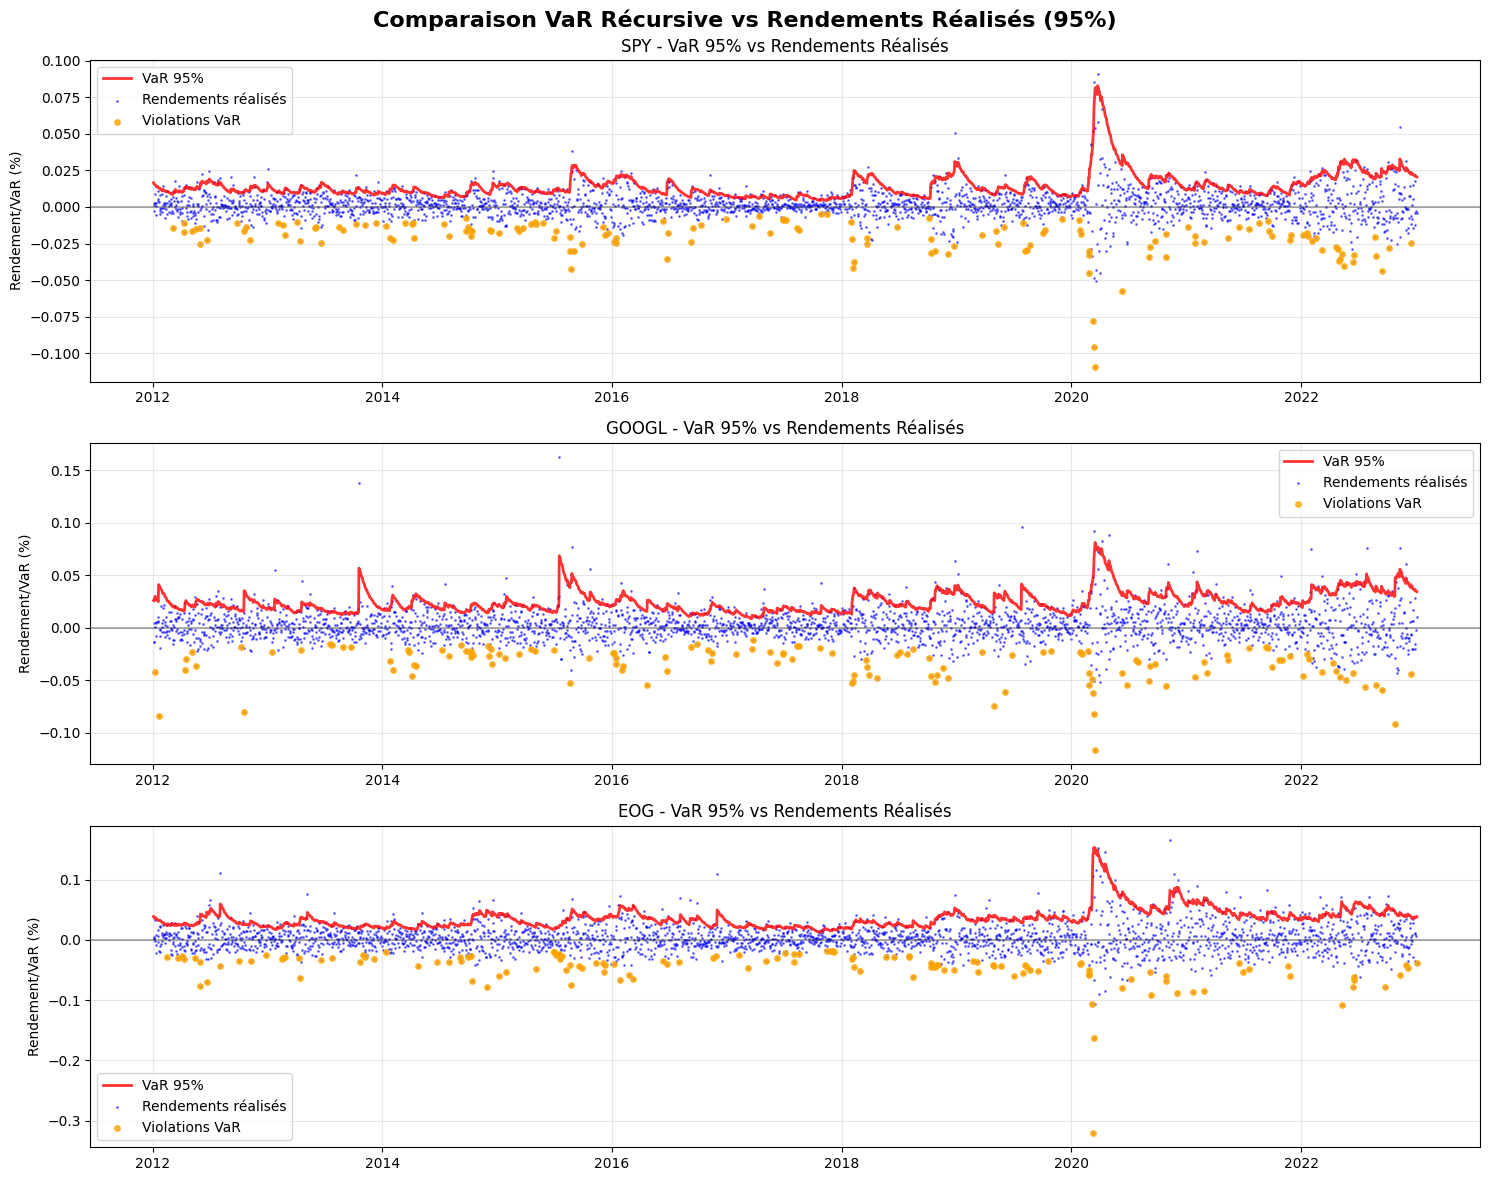


=== ANALYSE DES VIOLATIONS VaR 95% ===

SPY (Indice de marché):
  Taux de violation observé: 5.46%
  Taux de violation théorique: 5.00%
  Nombre de violations: 151/2768
  Première violation: 2012-03-06
  Dernière violation: 2022-12-15

GOOGL (Secteur technologique):
  Taux de violation observé: 4.80%
  Taux de violation théorique: 5.00%
  Nombre de violations: 133/2768
  Première violation: 2012-01-09
  Dernière violation: 2022-12-15

EOG (Secteur énergétique):
  Taux de violation observé: 4.80%
  Taux de violation théorique: 5.00%
  Nombre de violations: 133/2768
  Première violation: 2012-02-17
  Dernière violation: 2023-01-03



In [53]:
# --- Problème 2(d): VaR Récursive (Volatilité à pondération exponentielle) ---

# Paramètres pour le modèle EWMA (Exponentially Weighted Moving Average)
lambda_ewma = 0.94
alphas_var = {'95%': 0.05, '99%': 0.01} # Niveaux de confiance à calculer

# Préparer le DataFrame pour stocker les résultats
df_var_recursive = df_clean.copy()
df_var_recursive['ewma_vol'] = np.nan
df_var_recursive['var_recursive_95'] = np.nan
df_var_recursive['var_recursive_99'] = np.nan # Ajout pour la VaR 99%

print("=== Calcul de la VaR Récursive (EWMA) pour les niveaux 95% et 99% ===\n")

# Boucle sur chaque titre à analyser
for ticker in tickers_analyse_b:
    print(f"Traitement pour {ticker}...")
    
    # Isoler les rendements pour le ticker
    returns = df_var_recursive.loc[df_var_recursive['ticker'] == ticker, 'returns']
    
    # Initialisation de la volatilité
    vol_t_minus_1 = returns.std()
    
    # Itérer sur les rendements pour calculer la volatilité EWMA
    ewma_vol_series = []
    for r_t_minus_1 in returns:
        var_t = lambda_ewma * (vol_t_minus_1 ** 2) + (1 - lambda_ewma) * (r_t_minus_1 ** 2)
        vol_t = np.sqrt(var_t)
        ewma_vol_series.append(vol_t)
        vol_t_minus_1 = vol_t
        
    # Stocker la série de volatilité calculée
    df_var_recursive.loc[df_var_recursive['ticker'] == ticker, 'ewma_vol'] = ewma_vol_series
    
    # Calculer et stocker la VaR pour chaque niveau de confiance
    # On suppose un rendement moyen de 0 pour simplifier
    mu = returns.mean()
    for label, alpha in alphas_var.items():
        z_score = norm.ppf(alpha)
        var_recursive = -(mu + np.array(ewma_vol_series) * z_score)
        
        # Stocker la VaR dans la colonne correspondante
        col_name = f'var_recursive_{label.replace("%", "")}'
        df_var_recursive.loc[df_var_recursive['ticker'] == ticker, col_name] = var_recursive

print("\nCalcul terminé. Génération des graphiques...")

# --- Graphique 1: Évolution de la VaR Récursive (EWMA) à 95% ---
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle('Évolution de la VaR Récursive (EWMA) à 95%', fontsize=16, fontweight='bold')

colors = plt.cm.viridis(np.linspace(0, 1, len(tickers_analyse_b)))

for i, ticker in enumerate(tickers_analyse_b):
    data_ticker = df_var_recursive[df_var_recursive['ticker'] == ticker]
    ax.plot(data_ticker['date'], data_ticker['var_recursive_95'], 
            linewidth=1.5, label=f'VaR 95% pour {ticker}', color=colors[i])

ax.set_title('Comparaison de la VaR 95% pour les différents tickers')
ax.set_ylabel('VaR (Perte potentielle en %)')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Graphique 2: Évolution de la VaR Récursive (EWMA) à 99% ---
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle('Évolution de la VaR Récursive (EWMA) à 99%', fontsize=16, fontweight='bold')

for i, ticker in enumerate(tickers_analyse_b):
    data_ticker = df_var_recursive[df_var_recursive['ticker'] == ticker]
    ax.plot(data_ticker['date'], data_ticker['var_recursive_99'], 
            linewidth=1.5, label=f'VaR 99% pour {ticker}', color=colors[i])

ax.set_title('Comparaison de la VaR 99% pour les différents tickers')
ax.set_ylabel('VaR (Perte potentielle en %)')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Graphique 3: Comparaison VaR vs Rendements Réalisés (95%) ---
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Comparaison VaR Récursive vs Rendements Réalisés (95%)', fontsize=16, fontweight='bold')

for i, ticker in enumerate(tickers_analyse_b):
    data_ticker = df_var_recursive[df_var_recursive['ticker'] == ticker]
    
    ax = axes[i]
    
    # VaR 95% (ligne rouge)
    ax.plot(data_ticker['date'], data_ticker['var_recursive_95'], 
            color='red', linewidth=2, label='VaR 95%', alpha=0.8)
    
    # Rendements réalisés (points bleus)
    ax.scatter(data_ticker['date'], data_ticker['returns'], 
              color='blue', s=1, alpha=0.5, label='Rendements réalisés')
    
    # Violations (rendements < -VaR)
    violations = data_ticker['returns'] < -data_ticker['var_recursive_95']
    if violations.any():
        ax.scatter(data_ticker.loc[violations, 'date'], 
                  data_ticker.loc[violations, 'returns'],
                  color='orange', s=15, label='Violations VaR', alpha=0.8)
    
    ax.set_title(f'{ticker} - VaR 95% vs Rendements Réalisés')
    ax.set_ylabel('Rendement/VaR (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

# --- Analyse Quantitative des Violations ---
print("\n=== ANALYSE DES VIOLATIONS VaR 95% ===\n")

for ticker in tickers_analyse_b:
    data_ticker = df_var_recursive[df_var_recursive['ticker'] == ticker]
    # Supprimer les valeurs NaN pour le calcul des violations
    data_clean = data_ticker.dropna(subset=['returns', 'var_recursive_95'])
    
    violations = data_clean['returns'] < -data_clean['var_recursive_95']
    taux_violation = violations.mean() * 100
    
    print(f"{ticker} ({secteurs_mapping[ticker]}):")
    print(f"  Taux de violation observé: {taux_violation:.2f}%")
    print(f"  Taux de violation théorique: 5.00%")
    print(f"  Nombre de violations: {violations.sum()}/{len(violations)}")
    
    # Identifier quelques périodes de violations importantes
    if violations.any():
        dates_violations = data_clean.loc[violations, 'date']
        if len(dates_violations) > 0:
            print(f"  Première violation: {dates_violations.iloc[0].strftime('%Y-%m-%d')}")
            if len(dates_violations) > 1:
                print(f"  Dernière violation: {dates_violations.iloc[-1].strftime('%Y-%m-%d')}")
    print()


In [55]:
# --- Problème 2(e): Stress Testing des Modèles de VaR ---

print("=== Initialisation du Stress Test ===\n")

# 1. Définir le scénario de stress
# Nous insérons une panique boursière simulée de 5 jours au début de la crise de la COVID-19
shock_date_start = '2020-03-09'
shock_returns = [-0.08, -0.10, -0.07, -0.09, -0.06] # Rendements négatifs importants
shock_duration = len(shock_returns)

# Créer une copie des données pour le stress test
df_stressed = df_clean.copy()

print(f"Injection d'un choc de {shock_duration} jours à partir du {shock_date_start}...")

# Injecter le choc pour chaque ticker analysé
for ticker in tickers_analyse_b:
    # Trouver les indices des dates à remplacer
    ticker_indices = df_stressed[df_stressed['ticker'] == ticker].index
    shock_start_date_utc = pd.to_datetime(shock_date_start).tz_localize('UTC')
    start_date_loc = df_stressed.loc[ticker_indices][df_stressed.loc[ticker_indices, 'date'] >= shock_start_date_utc].index[0]
    
    # S'assurer de ne pas dépasser la fin du DataFrame pour ce ticker
    end_loc = start_date_loc + shock_duration
    if end_loc > ticker_indices[-1]:
        # Ajuster la durée si le choc dépasse la fin des données
        shock_duration_adjusted = ticker_indices[-1] - start_date_loc + 1
        df_stressed.loc[start_date_loc:ticker_indices[-1], 'returns'] = shock_returns[:shock_duration_adjusted]
    else:
        df_stressed.loc[start_date_loc:end_loc-1, 'returns'] = shock_returns

print("Choc injecté. Recalcul des modèles de VaR sur les données stressées...\n")

# 2. Fonction pour calculer la VaR récursive pour une série
def get_recursive_var_series(returns_series, lambda_ewma=0.94, alpha=0.05):
    mu = returns_series.mean()
    z_score = norm.ppf(alpha)
    
    vol_t_minus_1 = returns_series.std()
    ewma_vol_series = []
    for r_t_minus_1 in returns_series:
        var_t = lambda_ewma * (vol_t_minus_1 ** 2) + (1 - lambda_ewma) * (r_t_minus_1 ** 2)
        vol_t = np.sqrt(var_t)
        ewma_vol_series.append(vol_t)
        vol_t_minus_1 = vol_t
        
    return -(mu + np.array(ewma_vol_series) * z_score)

# 3. Calculer les VaR avant et après le choc pour comparaison
stress_test_results = []
alphas_stress = [0.05] # 95% seulement pour simplicité et cohérence avec 2(d)

for ticker in tickers_analyse_b:
    # Isoler les données originales et stressées
    original_returns = df_clean[df_clean['ticker'] == ticker]
    stressed_returns = df_stressed[df_stressed['ticker'] == ticker]

    for alpha in alphas_stress:
        conf_level = f"{(1-alpha):.0%}"
        
        # --- VaR sur données originales ---
        var_hist_orig = -original_returns['returns'].quantile(alpha)
        var_gauss_orig = -(original_returns['returns'].mean() + original_returns['returns'].std() * norm.ppf(alpha))
        
        # Pour la récursive, on prend la valeur juste avant le choc
        col_name = f'var_recursive_{int((1-alpha)*100)}'
        var_rec_series_orig = df_var_recursive[df_var_recursive['ticker'] == ticker][col_name]
        shock_start_date_utc = pd.to_datetime(shock_date_start).tz_localize('UTC')
        loc_before_shock = original_returns[original_returns['date'] < shock_start_date_utc].index[-1]
        var_rec_before_shock = var_rec_series_orig.loc[loc_before_shock]

        # --- VaR sur données stressées ---
        var_hist_stressed = -stressed_returns['returns'].quantile(alpha)
        var_gauss_stressed = -(stressed_returns['returns'].mean() + stressed_returns['returns'].std() * norm.ppf(alpha))
        
        # Pour la récursive, on recalcule la série sur les données stressées et on prend la valeur juste après
        var_rec_series_stressed = get_recursive_var_series(stressed_returns['returns'], alpha=alpha)
        shock_end_date = pd.to_datetime(shock_date_start) + pd.Timedelta(days=shock_duration - 1)
        shock_end_date_utc = shock_end_date.tz_localize('UTC')
        loc_after_shock = stressed_returns[stressed_returns['date'] > shock_end_date_utc].index[0]
        var_rec_after_shock = var_rec_series_stressed[stressed_returns.index.get_loc(loc_after_shock)]

        # Ajouter les résultats
        stress_test_results.extend([
            {'Ticker': ticker, 'Modèle': 'Historique', 'Confiance': conf_level, 'VaR Avant Choc': var_hist_orig, 'VaR Après Choc': var_hist_stressed},
            {'Ticker': ticker, 'Modèle': 'Gaussien', 'Confiance': conf_level, 'VaR Avant Choc': var_gauss_orig, 'VaR Après Choc': var_gauss_stressed},
            {'Ticker': ticker, 'Modèle': 'Récursif (EWMA)', 'Confiance': conf_level, 'VaR Avant Choc': var_rec_before_shock, 'VaR Après Choc': var_rec_after_shock},
        ])

# 4. Créer et afficher le DataFrame de comparaison
comparison_stress_df = pd.DataFrame(stress_test_results)
comparison_stress_df['Variation (%)'] = ((comparison_stress_df['VaR Après Choc'] - comparison_stress_df['VaR Avant Choc']) / comparison_stress_df['VaR Avant Choc']) * 100

print("=== Comparaison de la Réactivité des Modèles de VaR au Choc Simulé (95%) ===\n")
print(comparison_stress_df.to_string(index=False))


=== Initialisation du Stress Test ===

Injection d'un choc de 5 jours à partir du 2020-03-09...
Choc injecté. Recalcul des modèles de VaR sur les données stressées...

=== Comparaison de la Réactivité des Modèles de VaR au Choc Simulé (95%) ===

Ticker          Modèle Confiance  VaR Avant Choc  VaR Après Choc  Variation (%)
   SPY      Historique       95%        0.016160        0.016258       0.607775
   SPY        Gaussien       95%        0.017097        0.017368       1.582730
   SPY Récursif (EWMA)       95%        0.035668        0.074714     109.467335
 GOOGL      Historique       95%        0.025128        0.025180       0.205481
 GOOGL        Gaussien       95%        0.026930        0.027222       1.085002
 GOOGL Récursif (EWMA)       95%        0.040530        0.076405      88.515826
   EOG      Historique       95%        0.035645        0.035795       0.422034
   EOG        Gaussien       95%        0.040143        0.038730      -3.520141
   EOG Récursif (EWMA)       95%  

In [63]:
# --- Problème 2(f): Test de Couverture pour les Modèles de VaR ---

print("=== Test de Couverture des Modèles de VaR ===\n")
print("Formule: S = (#violations - α*T) / sqrt(α*(1-α)*T)")
print("Sous H0: le modèle a le bon taux de violation → S ~ N(0,1)")
print("Rejet si |S| > 1.96 (seuil 5%)\n")

from scipy.stats import norm

# Paramètres
alpha = 0.05  # Niveau de confiance 95%
coverage_test_results = []

for ticker in tickers_analyse_b:
    # 1. VaR Historique
    returns = df_clean[df_clean['ticker'] == ticker]['returns']
    var_hist = -returns.quantile(alpha)
    violations_hist = returns < -var_hist
    num_violations_hist = violations_hist.sum()
    T = len(returns)
    
    expected_violations = alpha * T
    S_hist = (num_violations_hist - expected_violations) / np.sqrt(alpha * (1 - alpha) * T)
    p_value_hist = 2 * (1 - norm.cdf(abs(S_hist)))
    reject_hist = abs(S_hist) > 1.96
    
    # 2. VaR Gaussienne
    mu = returns.mean()
    sigma = returns.std()
    z_score = norm.ppf(alpha)
    var_gauss = -(mu + sigma * z_score)
    violations_gauss = returns < -var_gauss
    num_violations_gauss = violations_gauss.sum()
    
    S_gauss = (num_violations_gauss - expected_violations) / np.sqrt(alpha * (1 - alpha) * T)
    p_value_gauss = 2 * (1 - norm.cdf(abs(S_gauss)))
    reject_gauss = abs(S_gauss) > 1.96
    
    # 3. VaR Récursive
    data_ticker = df_var_recursive[df_var_recursive['ticker'] == ticker]
    data_clean_recursive = data_ticker.dropna(subset=['returns', 'var_recursive_95'])
    
    var_recursive_series = data_clean_recursive['var_recursive_95']
    returns_recursive = data_clean_recursive['returns']
    violations_recursive = returns_recursive < -var_recursive_series
    num_violations_recursive = violations_recursive.sum()
    T_recursive = len(returns_recursive)
    
    expected_violations_recursive = alpha * T_recursive
    S_recursive = (num_violations_recursive - expected_violations_recursive) / np.sqrt(alpha * (1 - alpha) * T_recursive)
    p_value_recursive = 2 * (1 - norm.cdf(abs(S_recursive)))
    reject_recursive = abs(S_recursive) > 1.96
    
    # Afficher les détails par ticker
    print(f"=== {ticker} ({secteurs_mapping[ticker]}) ===")
    print(f"Observations totales: {T:,}")
    print(f"Violations attendues (5%): {expected_violations:.1f}")
    print(f"")
    print(f"VaR Historique:")
    print(f"  Violations observées: {num_violations_hist}")
    print(f"  Taux empirique: {num_violations_hist/T*100:.2f}%")
    print(f"  Statistique S: {S_hist:.3f}")
    print(f"  Rejet H0: {'Oui' if reject_hist else 'Non'}")
    print(f"")
    print(f"VaR Gaussienne:")
    print(f"  Violations observées: {num_violations_gauss}")
    print(f"  Taux empirique: {num_violations_gauss/T*100:.2f}%")
    print(f"  Statistique S: {S_gauss:.3f}")
    print(f"  Rejet H0: {'Oui' if reject_gauss else 'Non'}")
    print(f"")
    print(f"VaR Récursive (EWMA):")
    print(f"  Observations: {T_recursive:,}")
    print(f"  Violations observées: {num_violations_recursive}")
    print(f"  Taux empirique: {num_violations_recursive/T_recursive*100:.2f}%")
    print(f"  Statistique S: {S_recursive:.3f}")
    print(f"  Rejet H0: {'Oui' if reject_recursive else 'Non'}")
    print(f"\n" + "-"*60 + "\n")
    
    # Stocker les résultats
    coverage_test_results.extend([
        {
            'Ticker': ticker,
            'Modèle': 'Historique',
            'Taux_Empirique_%': num_violations_hist/T*100,
            'Statistique_S': S_hist,
            'Rejet_H0': 'Oui' if reject_hist else 'Non'
        },
        {
            'Ticker': ticker,
            'Modèle': 'Gaussien',
            'Taux_Empirique_%': num_violations_gauss/T*100,
            'Statistique_S': S_gauss,
            'Rejet_H0': 'Oui' if reject_gauss else 'Non'
        },
        {
            'Ticker': ticker,
            'Modèle': 'Récursif (EWMA)',
            'Taux_Empirique_%': num_violations_recursive/T_recursive*100,
            'Statistique_S': S_recursive,
            'Rejet_H0': 'Oui' if reject_recursive else 'Non'
        }
    ])

# Créer et afficher le tableau de synthèse
coverage_df = pd.DataFrame(coverage_test_results)
print("\n=== TABLEAU DE SYNTHÈSE DU TEST DE COUVERTURE ===\n")
print(coverage_df.round(3).to_string(index=False))

=== Test de Couverture des Modèles de VaR ===

Formule: S = (#violations - α*T) / sqrt(α*(1-α)*T)
Sous H0: le modèle a le bon taux de violation → S ~ N(0,1)
Rejet si |S| > 1.96 (seuil 5%)

=== SPY (Indice de marché) ===
Observations totales: 2,768
Violations attendues (5%): 138.4

VaR Historique:
  Violations observées: 139
  Taux empirique: 5.02%
  Statistique S: 0.052
  Rejet H0: Non

VaR Gaussienne:
  Violations observées: 123
  Taux empirique: 4.44%
  Statistique S: -1.343
  Rejet H0: Non

VaR Récursive (EWMA):
  Observations: 2,768
  Violations observées: 151
  Taux empirique: 5.46%
  Statistique S: 1.099
  Rejet H0: Non

------------------------------------------------------------

=== GOOGL (Secteur technologique) ===
Observations totales: 2,768
Violations attendues (5%): 138.4

VaR Historique:
  Violations observées: 139
  Taux empirique: 5.02%
  Statistique S: 0.052
  Rejet H0: Non

VaR Gaussienne:
  Violations observées: 117
  Taux empirique: 4.23%
  Statistique S: -1.866
  R

In [64]:
# --- Problème 2(g): Test de Séquences (Run Test) pour les Violations VaR ---

print("=== Test de Séquences pour l'Indépendance des Violations VaR ===\n")
print("H0: Les violations sont indépendantes (pas de regroupement)")
print("H1: Les violations sont dépendantes (regroupement significatif)")
print("Rejet si |Z| > 1.96 (seuil 5%)\n")

from scipy.stats import norm

def run_test_violations(violations_series):
    """
    Effectue un test de séquences sur une série binaire de violations.
    
    Parameters:
    violations_series: Series pandas de booléens (True = violation, False = non-violation)
    
    Returns:
    dict avec les statistiques du test
    """
    # Convertir en série binaire (1 = violation, 0 = non-violation)
    binary_series = violations_series.astype(int)
    
    # Nombre total d'observations
    n = len(binary_series)
    
    # Nombre de violations et non-violations
    n1 = binary_series.sum()  # violations
    n0 = n - n1  # non-violations
    
    if n1 == 0 or n0 == 0:
        return {
            'n_total': n,
            'n_violations': n1,
            'n_non_violations': n0,
            'runs_observed': 0,
            'runs_expected': 0,
            'runs_variance': 0,
            'z_statistic': 0,
            'p_value': 1,
            'reject_h0': False,
            'interpretation': 'Pas assez de variations pour tester'
        }
    
    # Compter le nombre de séquences (runs)
    runs_observed = 1
    for i in range(1, n):
        if binary_series.iloc[i] != binary_series.iloc[i-1]:
            runs_observed += 1
    
    # Calcul des statistiques théoriques sous H0
    runs_expected = (2 * n1 * n0) / n + 1
    runs_variance = (2 * n1 * n0 * (2 * n1 * n0 - n)) / (n**2 * (n - 1))
    
    # Statistique Z avec correction de continuité
    if runs_observed > runs_expected:
        z_statistic = (runs_observed - 0.5 - runs_expected) / np.sqrt(runs_variance)
    else:
        z_statistic = (runs_observed + 0.5 - runs_expected) / np.sqrt(runs_variance)
    
    # P-value (test bilatéral)
    p_value = 2 * (1 - norm.cdf(abs(z_statistic)))
    
    # Décision
    reject_h0 = abs(z_statistic) > 1.96
    
    return {
        'n_total': n,
        'n_violations': n1,
        'n_non_violations': n0,
        'runs_observed': runs_observed,
        'runs_expected': runs_expected,
        'runs_variance': runs_variance,
        'z_statistic': z_statistic,
        'p_value': p_value,
        'reject_h0': reject_h0,
        'interpretation': 'Regroupement significatif' if reject_h0 else 'Pas de regroupement significatif'
    }

# Effectuer le test pour chaque modèle et ticker
run_test_results = []

for ticker in tickers_analyse_b:
    print(f"=== {ticker} ({secteurs_mapping[ticker]}) ===")
    
    # 1. VaR Historique
    returns = df_clean[df_clean['ticker'] == ticker]['returns']
    var_hist = -returns.quantile(0.05)
    violations_hist = returns < -var_hist
    
    run_result_hist = run_test_violations(violations_hist)
    
    print(f"VaR Historique:")
    print(f"  Observations totales: {run_result_hist['n_total']:,}")
    print(f"  Violations: {run_result_hist['n_violations']}")
    print(f"  Séquences observées: {run_result_hist['runs_observed']}")
    print(f"  Séquences attendues: {run_result_hist['runs_expected']:.1f}")
    print(f"  Statistique Z: {run_result_hist['z_statistic']:.3f}")
    print(f"  P-value: {run_result_hist['p_value']:.4f}")
    print(f"  Rejet H0: {'Oui' if run_result_hist['reject_h0'] else 'Non'}")
    print(f"  Interprétation: {run_result_hist['interpretation']}")
    print()
    
    # 2. VaR Gaussienne
    mu = returns.mean()
    sigma = returns.std()
    z_score = norm.ppf(0.05)
    var_gauss = -(mu + sigma * z_score)
    violations_gauss = returns < -var_gauss
    
    run_result_gauss = run_test_violations(violations_gauss)
    
    print(f"VaR Gaussienne:")
    print(f"  Observations totales: {run_result_gauss['n_total']:,}")
    print(f"  Violations: {run_result_gauss['n_violations']}")
    print(f"  Séquences observées: {run_result_gauss['runs_observed']}")
    print(f"  Séquences attendues: {run_result_gauss['runs_expected']:.1f}")
    print(f"  Statistique Z: {run_result_gauss['z_statistic']:.3f}")
    print(f"  P-value: {run_result_gauss['p_value']:.4f}")
    print(f"  Rejet H0: {'Oui' if run_result_gauss['reject_h0'] else 'Non'}")
    print(f"  Interprétation: {run_result_gauss['interpretation']}")
    print()
    
    # 3. VaR Récursive
    data_ticker = df_var_recursive[df_var_recursive['ticker'] == ticker]
    data_clean_recursive = data_ticker.dropna(subset=['returns', 'var_recursive_95'])
    
    var_recursive_series = data_clean_recursive['var_recursive_95']
    returns_recursive = data_clean_recursive['returns']
    violations_recursive = returns_recursive < -var_recursive_series
    
    run_result_recursive = run_test_violations(violations_recursive)
    
    print(f"VaR Récursive (EWMA):")
    print(f"  Observations totales: {run_result_recursive['n_total']:,}")
    print(f"  Violations: {run_result_recursive['n_violations']}")
    print(f"  Séquences observées: {run_result_recursive['runs_observed']}")
    print(f"  Séquences attendues: {run_result_recursive['runs_expected']:.1f}")
    print(f"  Statistique Z: {run_result_recursive['z_statistic']:.3f}")
    print(f"  P-value: {run_result_recursive['p_value']:.4f}")
    print(f"  Rejet H0: {'Oui' if run_result_recursive['reject_h0'] else 'Non'}")
    print(f"  Interprétation: {run_result_recursive['interpretation']}")
    print(f"\n" + "-"*70 + "\n")
    
    # Stocker les résultats pour le tableau de synthèse
    run_test_results.extend([
        {
            'Ticker': ticker,
            'Modèle': 'Historique',
            'Violations': run_result_hist['n_violations'],
            'Séquences_Obs': run_result_hist['runs_observed'],
            'Séquences_Att': round(run_result_hist['runs_expected'], 1),
            'Statistique_Z': run_result_hist['z_statistic'],
            'Rejet_H0': 'Oui' if run_result_hist['reject_h0'] else 'Non'
        },
        {
            'Ticker': ticker,
            'Modèle': 'Gaussien',
            'Violations': run_result_gauss['n_violations'],
            'Séquences_Obs': run_result_gauss['runs_observed'],
            'Séquences_Att': round(run_result_gauss['runs_expected'], 1),
            'Statistique_Z': run_result_gauss['z_statistic'],
            'Rejet_H0': 'Oui' if run_result_gauss['reject_h0'] else 'Non'
        },
        {
            'Ticker': ticker,
            'Modèle': 'Récursif (EWMA)',
            'Violations': run_result_recursive['n_violations'],
            'Séquences_Obs': run_result_recursive['runs_observed'],
            'Séquences_Att': round(run_result_recursive['runs_expected'], 1),
            'Statistique_Z': run_result_recursive['z_statistic'],
            'Rejet_H0': 'Oui' if run_result_recursive['reject_h0'] else 'Non'
        }
    ])

# Créer et afficher le tableau de synthèse
run_test_df = pd.DataFrame(run_test_results)
print("=== TABLEAU DE SYNTHÈSE DU TEST DE SÉQUENCES ===\n")
print(run_test_df.round(3).to_string(index=False))

=== Test de Séquences pour l'Indépendance des Violations VaR ===

H0: Les violations sont indépendantes (pas de regroupement)
H1: Les violations sont dépendantes (regroupement significatif)
Rejet si |Z| > 1.96 (seuil 5%)

=== SPY (Indice de marché) ===
VaR Historique:
  Observations totales: 2,768
  Violations: 139
  Séquences observées: 239
  Séquences attendues: 265.0
  Statistique Z: -5.098
  P-value: 0.0000
  Rejet H0: Oui
  Interprétation: Regroupement significatif

VaR Gaussienne:
  Observations totales: 2,768
  Violations: 123
  Séquences observées: 215
  Séquences attendues: 236.1
  Statistique Z: -4.613
  P-value: 0.0000
  Rejet H0: Oui
  Interprétation: Regroupement significatif

VaR Récursive (EWMA):
  Observations totales: 2,768
  Violations: 151
  Séquences observées: 281
  Séquences attendues: 286.5
  Statistique Z: -0.927
  P-value: 0.3537
  Rejet H0: Non
  Interprétation: Pas de regroupement significatif

-----------------------------------------------------------------